# **Klasifikasi Digit dari Audio dengan Model LSTM**
- Nama: Muhammad Ilham Ramadhan
- NIM: 2110511078
- Matkul: Pembelajaran Mesin
- Kelas: B

## Import Library

In [1]:
import os
import random
import librosa
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

## Load Folder Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder_path = "/content/drive/MyDrive/Colab Notebooks/Machine Learning/recordings"

Dataset berisi direktori rekaman di mana dapat ditemukan kumpulan data audio yang terdiri dari rekaman angka-angka yang diucapkan dalam file wav pada 8kHz. Rekaman dipotong sehingga awal dan akhir rekaman hening. Detail dari audio ini:

- 3 pembicara
- 1.500 rekaman (50 dari setiap angka per pembicara)
- Pengucapan bahasa Inggris

File diberi format nama:
- digitLabel_Pembicara_index.wav
- Contoh: 7_jackson_32.wav

## Pengolahan Data Audio
Kedua fungsi ini memainkan peran penting dalam menstandardisasi dimensi atau panjang data suara, sehingga cocok untuk digunakan sebagai input dalam model LSTM.

In [4]:
pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
pad2d = lambda a, i: a[:, 0: i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0],i - a.shape[1]))))

1. pad1d

Fungsi ini digunakan untuk memproses data gelombang suara 1D. Fungsi pad1d mengambil dua argumen: a, yang merupakan data gelombang suara, dan i, yang merupakan panjang yang diinginkan.
* Jika panjang data audio a (jumlah elemen dalam array a) lebih besar dari atau sama dengan panjang yang diharapkan i, maka fungsi akan memotong data audio a menjadi sepanjang i. Ini berarti jika data audio sudah mencapai atau melebihi panjang yang diharapkan, maka tidak ada pengisian nol yang diperlukan.
* Jika panjang data audio a lebih kecil dari panjang yang diharapkan i, maka fungsi akan menambahkan nilai-nol ke akhir data audio sehingga panjang data audio mencapai i.

2. pad2d

Fungsi ini digunakan untuk memproses data 2D seperti spektrogram atau matriks MFCC. Fungsi pad2d juga mengambil dua argumen: a, yang merupakan data 2D, dan i, yang merupakan panjang kolom yang diinginkan.
* Jika dimensi kedua dari matriks a (jumlah kolom) lebih besar dari atau sama dengan panjang yang diharapkan i, maka fungsi akan memotong matriks a sehingga memiliki panjang dimensi kedua sepanjang i. Ini berarti jika matriks a sudah mencapai atau melebihi panjang yang diharapkan, maka tidak ada pengisian nol yang diperlukan.
* Jika dimensi kedua dari matriks a lebih kecil dari panjang yang diharapkan i, maka fungsi akan menambahkan nilai-nol ke akhir setiap baris matriks sehingga panjang dimensi kedua matriks mencapai i.

## Inisialisasi Variabel

In [5]:
speakers = ['theo', 'nicolas', 'jackson']
train_mfccs = []
train_y = []

test_mfccs = []
test_y = []

1. **speakers** adalah daftar pembicara yang Anda ingin berikan label dalam data audio.
3. **train_mfccs** dan **test_mfccs** berisi matriks MFCC yang sesuai dengan data audio pelatihan dan pengujian.
4. **train_y** dan **test_y** berisi label digit yang sesuai dengan data audio pelatihan dan pengujian.

## Loop untuk Memproses File Audio

In [6]:
for fname in os.listdir(folder_path):
    try:
        if '.wav' not in fname:
            continue

        struct = fname.split('_')
        digit = struct[0]
        speaker = struct[2]
        wav, sr = librosa.load(os.path.join(folder_path, fname))
        wav = librosa.util.normalize(wav)

        mfcc = librosa.feature.mfcc(y=wav, sr=sr)
        mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
        padded_mfcc = pad2d(mfcc, 40)

        if random.random() < 0.2:
            test_mfccs.append(padded_mfcc)
            test_y.append(digit)
        else:
            train_mfccs.append(padded_mfcc)
            train_y.append(digit)

    except Exception as e:
        print(fname, e)
        raise

1. **Loop Melalui File Audio**:
`for fname in os.listdir(folder_path)` digunakan untuk mengiterasi melalui semua file yang ada di direktori folder_path.
2. **Pengecualian File Non-WAV**:
Dalam kondisi `if '.wav' not in fname:`, kode tersebut memeriksa apakah file tersebut adalah file audio dalam format WAV. Jika bukan, kode akan melanjutkan ke file berikutnya.
3. **Pemisahan Nama File**:
`struct = fname.split('_')` digunakan untuk membagi nama file menjadi beberapa bagian berdasarkan karakter _ untuk mendapatkan informasi seperti digit (angka) dan pembicara (speaker) dari nama file.
4. **Pembacaan dan Normalisasi Audio**:
`wav, sr = librosa.load(os.path.join(folder_path, fname))` digunakan untuk membaca file audio menggunakan Librosa dan mengambil gelombang suara (wav) serta tingkat sampel (sr). Gelombang suara ini kemudian dinormalisasi menggunakan `librosa.util.normalize(wav)`.
5. **Ekstraksi Fitur MFCC**:
```
mfcc = librosa.feature.mfcc(y=wav, sr=sr)
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
```
kode menghitung fitur MFCC (Mel-Frequency Cepstral Coefficients) dari gelombang suara. Fitur MFCC adalah representasi fitur yang sering digunakan dalam pemrosesan audio. Normalisasi juga diterapkan pada koefisien MFCC untuk memastikan konsistensi.
6. **Pemilihan Data Pengujian atau Pelatihan**: kode secara acak memutuskan apakah data audio tertentu akan digunakan untuk pengujian atau pelatihan. 20% data audio akan dipilih untuk pengujian, dan 80% sisanya akan menjadi bagian dari data pelatihan.
7. **Penambahan Data ke Data Pengujian atau Pelatihan**: Jika data audio dipilih untuk menjadi data pengujian (sesuai dengan hasil dari pengujian probabilitas), fitur MFCC dan label angkanya akan ditambahkan ke daftar data pengujian (test_mfccs dan test_y). Jika data tidak dipilih untuk menjadi data pengujian, maka akan ditambahkan ke data pelatihan.
8. **Penanganan Pengecualian**:
Jika terjadi kesalahan selama pemrosesan data audio, kesalahan tersebut akan dicetak dan program akan dihentikan.

## Data Preprocessing

In [7]:
train_mfccs = np.array(train_mfccs)
train_y = to_categorical(np.array(train_y))

test_mfccs = np.array(test_mfccs)
test_y = to_categorical(np.array(test_y))

Kode ini  bagian dari persiapan data untuk melatih dan menguji model klasifikasi suara digit:

1. Mengonversi fitur audio (MFCC) dan label digit menjadi format yang sesuai untuk pelatihan dan pengujian model.
2. Mengubah label digit menjadi vektor one-hot encoding, yang diperlukan untuk melatih model klasifikasi multikelas.

## Mendefinisikan Model LSTM
Keseluruhan arsitektur model ini adalah sebagai berikut: LSTM (64) -> LSTM (32) -> Dropout -> Dense (32) -> Dropout -> Dense (10).

In [8]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(20, 40), return_sequences=True,
                        kernel_initializer=tf.keras.initializers.he_uniform()),
    tf.keras.layers.LSTM(32, return_sequences=False,
                        kernel_initializer=tf.keras.initializers.he_uniform(),
                        kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu',
                        kernel_initializer=tf.keras.initializers.he_uniform(),
                        kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])


1. lapisan LSTM pertama
```
tf.keras.layers.LSTM(64, input_shape=(20, 40), return_sequences=True,
                       kernel_initializer=tf.keras.initializers.he_uniform())
```
Terdapat 64 unit LSTM dalam lapisan ini. Bentuk masukan (input shape) adalah matriks dengan dimensi (20, 40), yang sesuai dengan fitur-fitur MFCC yang dihasilkan dari data audio. Lapisan ini mengembalikan urutan (sequences) sehingga outputnya adalah urutan dari hasil LSTM.


2. **lapisan LSTM kedua**
```
tf.keras.layers.LSTM(32, return_sequences=False,
                       kernel_initializer=tf.keras.initializers.he_uniform(),
                       kernel_regularizer=tf.keras.regularizers.l2(0.01))
```
Terdapat 32 unit LSTM dalam lapisan ini. return_sequences=False mengindikasikan bahwa lapisan ini tidak mengembalikan urutan, sehingga outputnya adalah vektor tunggal.

3. **Lapisan Dropout**
```
tf.keras.layers.Dropout(0.5)
```
Lapisan dropout digunakan untuk mengurangi overfitting. Ini menghilangkan 50% dari neuron secara acak selama pelatihan.

4. **lapisan Dense**
```
tf.keras.layers.Dense(32, activation='relu',
                       kernel_initializer=tf.keras.initializers.he_uniform(),
                       kernel_regularizer=tf.keras.regularizers.l2(0.001))
```
Fully Connected Layer dengan 32 neuron dan aktivasi ReLU. Lapisan ini digunakan untuk menggabungkan hasil dari lapisan LSTM ke dalam bentuk yang lebih cocok untuk klasifikasi.

5. **Lapisan Dropout Kedua**
```
tf.keras.layers.Dropout(0.3)
```
Sekali lagi, lapisan dropout digunakan untuk mengurangi overfitting dengan menghilangkan 30% dari neuron secara acak selama pelatihan.

6. **lapisan Dense Kedua**
```
tf.keras.layers.Dense(10, activation='softmax')
```
lapisan output dengan 10 neuron yang sesuai dengan jumlah kelas yang akan diprediksi. Aktivasi softmax digunakan di sini untuk menghasilkan probabilitas kelas dari output.

## Summary Model LSTM

In [9]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            26880     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 40682 (158.91 KB)
Trainable params: 40682 

## Mengcompile Model LSTM

In [10]:
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.008),
                  loss='categorical_crossentropy', metrics=['accuracy'])


## Pelatihan Model LSTM

In [11]:
history = lstm_model.fit(train_mfccs, train_y, epochs=30, batch_size=32, validation_data=(test_mfccs, test_y))

Epoch 1/30
38/38 [==============================] - 6s 45ms/step - loss: 3.2093 - accuracy: 0.2155 - val_loss: 2.1973 - val_accuracy: 0.3521
Epoch 2/30
38/38 [==============================] - 1s 20ms/step - loss: 2.0588 - accuracy: 0.3561 - val_loss: 1.7138 - val_accuracy: 0.5211
Epoch 3/30
38/38 [==============================] - 1s 22ms/step - loss: 1.8544 - accuracy: 0.4433 - val_loss: 1.6042 - val_accuracy: 0.5880
Epoch 4/30
38/38 [==============================] - 1s 19ms/step - loss: 1.5770 - accuracy: 0.5773 - val_loss: 1.3866 - val_accuracy: 0.6761
Epoch 5/30
38/38 [==============================] - 1s 20ms/step - loss: 1.4238 - accuracy: 0.6234 - val_loss: 1.2965 - val_accuracy: 0.6866
Epoch 6/30
38/38 [==============================] - 1s 20ms/step - loss: 1.3573 - accuracy: 0.6628 - val_loss: 1.1855 - val_accuracy: 0.7324
Epoch 7/30
38/38 [==============================] - 1s 21ms/step - loss: 1.2640 - accuracy: 0.6785 - val_loss: 1.1795 - val_accuracy: 0.7077
Epoch 8/30
38

## Prediksi dan Classification Report
Model LSTM yang telah dilatih sebelumnya digunakan untuk prediksi pada data pengujian test_mfccs. Lalu konversi hasil prediksi ke indeks kelas dan akhirnya mengeluarkan output classification report yang berisi berbagai metrik evaluasi, yaitu presisi, recall, F1-score, dan lain-lain.


In [12]:
predictions = lstm_model.predict(test_mfccs)
results = np.argmax(predictions, axis=1)
print(classification_report(test_y, to_categorical(results)))

9/9 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.82      0.86      0.84        21
           2       0.79      0.84      0.81        31
           3       0.85      0.92      0.88        25
           4       0.87      0.96      0.91        27
           5       0.97      0.95      0.96        37
           6       0.96      0.84      0.90        32
           7       0.84      0.91      0.87        23
           8       0.89      0.86      0.88        29
           9       0.96      0.84      0.90        32

   micro avg       0.90      0.90      0.90       284
   macro avg       0.90      0.90      0.90       284
weighted avg       0.90      0.90      0.90       284
 samples avg       0.90      0.90      0.90       284



## Confusion Matrix
Confusion matrix ini mengukur kinerja model klasifikasi pada data yang telah diketahui dengan baik, di mana label sebenarnya sudah diketahui. Maka dapat diidentifikasi kelas mana yang perlu ditingkatkan.

In [13]:
confusion = confusion_matrix(np.argmax(test_y, axis=1), results)

Parameter pertama adalah label sebenarnya dari data pengujian (test_y), dan parameter kedua adalah hasil prediksi yang sudah dikonversi ke indeks kelas

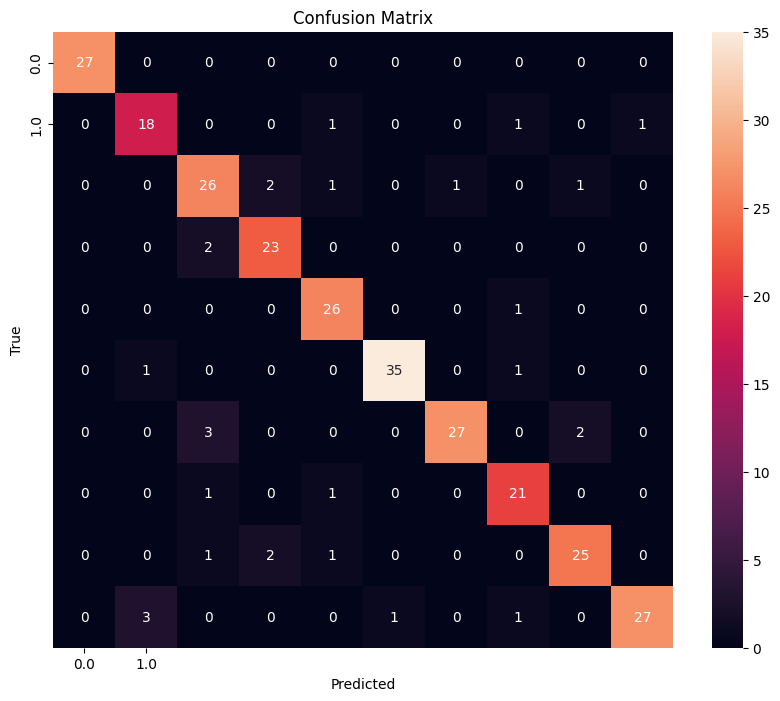

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', xticklabels=np.unique(test_y), yticklabels=np.unique(test_y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()